In [1]:
import glob
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython import display

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory('./',
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode=None)

Found 9999 images belonging to 3 classes.


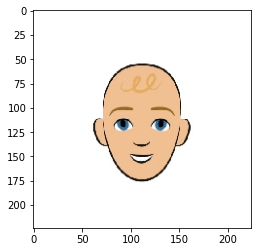

In [3]:
plt.imshow(train_generator[0][0],cmap='brg')

In [4]:
def make_generator_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(14*14*128, use_bias=False, input_shape=(100,)))
    #model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((14,14,128)))
    
    model.add(layers.Conv2DTranspose(64,(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32,(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16,(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #from here
    
#     model.add(layers.Conv2DTranspose(8,(5,5), strides=(2,2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    
#     model.add(layers.Conv2DTranspose(8,(5,5), strides=(2,2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    
    #to here
    model.add(layers.Conv2DTranspose(3,(5,5), strides=(2,2), padding='same', use_bias=False, activation='sigmoid'))
    
    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25088)             2508800   
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25088)             0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 64)       204800    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       2

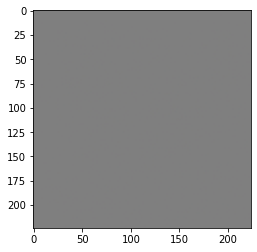

In [5]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = generated_image*255
generated_image = tf.cast(generated_image,tf.int32)
plt.imshow(generated_image[0], cmap='brg')
#print(generated_image)

In [6]:
def make_discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',input_shape=[224,224,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    #from here
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    #to here
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 56, 56, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)      

In [7]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-6.5563173]], shape=(1, 1), dtype=float32)


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 1

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([32,noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start=time.time()
        #print("epoch:",epoch)
        e=0
        for image_batch in dataset:
            e+=1
            train_step(image_batch)
            if e==312:
                break
            
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        
        if(epoch+1)%15==0:
            pass
            #checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch,seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  k=predictions*255
  k=tf.cast(k,tf.int32)
  plt.imshow(k[0],cmap='brg')

  #fig = plt.figure(figsize=(2,1))

  # for i in range(predictions.shape[0]):
  #     plt.subplot(2, 1, i+1)
  #     k=predictions[i]*255
  #     k=tf.cast(k,tf.int32)
  #     plt.imshow(k, cmap='brg')
  plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [16]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [17]:
checkpoint.restore(tf.train.latest_checkpoint('./training_checkpoints'))

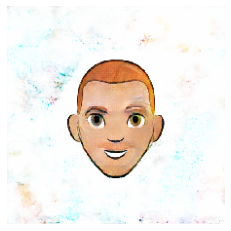

In [18]:
train(train_generator,EPOCHS)

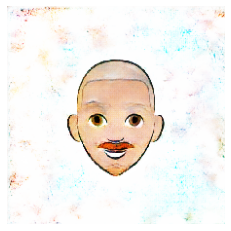

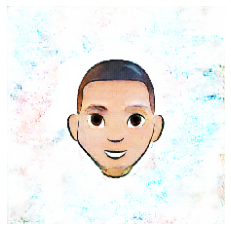

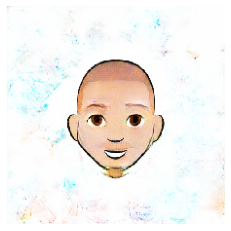

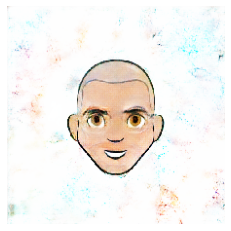

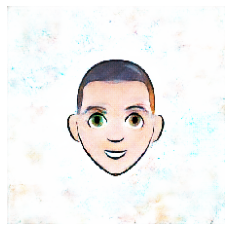

In [22]:
for v in range(5):
    ee = tf.random.normal([num_examples_to_generate, noise_dim])
    generate_and_save_images(generator,v,ee)

In [20]:
%rm -rf ./training_checkpoints

In [21]:
checkpoint.save(file_prefix=checkpoint_prefix)

'./training_checkpoints/ckpt-2'